In [1]:
from __future__ import print_function
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

## Parameters

In [23]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda = True

## Model Under Attack

In [32]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [33]:
# Mnist test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
                    datasets.MNIST("../data",
                                   train=False,
                                   download=True,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                   ])),
                    batch_size=1,
                    shuffle=True)

In [34]:
# Define what device we are using
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  False


In [35]:
model = Net().to(device)
model.load_state_dict(torch.load(pretrained_model, map_location="cpu"))
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## FGSM Attack

In [40]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0, 1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

## Testing Function

In [46]:
def test(model, device, test_loader, epsilon):
    # Accuracy counter
    correct = 0
    adv_examples = []
    # Loop over all examples in test set
    for data, target in test_loader:
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True
        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue
            
        # Calculate the loss
        loss = F.nll_loss(output, target)
        # Zero all existing gradients
        model.zero_grad()
        # Calcurate gradients of model in backward pass
        loss.backward()
        # Collect datagrad
        data_grad = data.grad.data
        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        # Re-classify the perturbed image
        output = model(perturbed_data)
        # Check for success
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            # Save som adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
    
    # Claculate final accuracy for this epsilon
    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Acccuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    
    # Return the accuracyand an adversarial example
    return final_acc, adv_examples

## Run Attack

In [47]:
accuracies = []
examples = []

# Run test for each epsilon 
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Acccuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Acccuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Acccuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Acccuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Acccuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Acccuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Acccuracy = 869 / 10000 = 0.0869


## Results
### Accuracy vs Epsilon

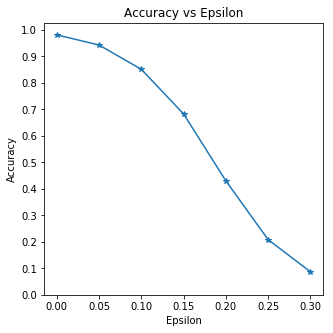

In [48]:
plt.figure(figsize=(5, 5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## Sample Adversarial Examples

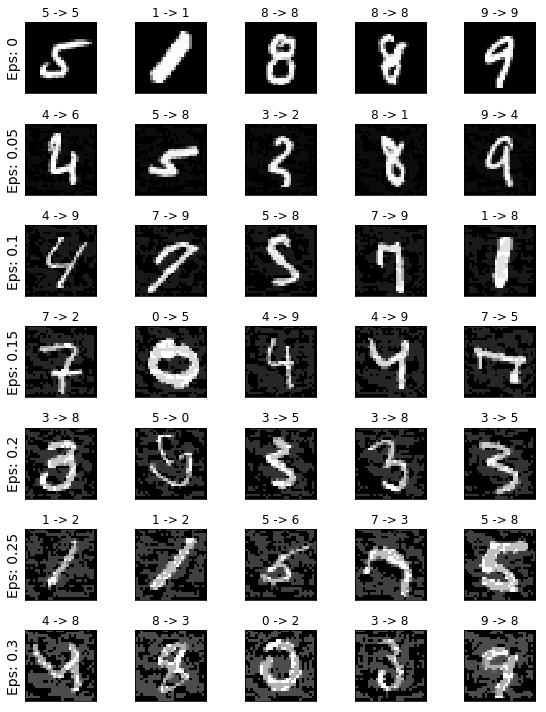

In [50]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8, 10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()